# Experiments of misinformation detection in three dimensions:
1. Content (What?)
1. Social (Who?)
1. Temporal (When?)

In [3]:
import pandas as pd
import numpy as np
import pickle

# Data manipulation

## Load data

In [46]:
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
print(df.columns)
df.head(3)

Index(['id', 'date', 'hour', 'ddi', 'country', 'country_iso3', 'ddd', 'state',
       'group', 'midia', 'url', 'characters', 'words', 'viral', 'shares',
       'text', 'misinformation'],
      dtype='object')


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1


## Timestamp

In [47]:
# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')

## Load and filter expanded labels
Labels expanded by cosine similarity in TF-IDF representation. If sim < 0.8, assign the label of the manually labelled data. However, it is necessary filter out noisy messages with little information. E.g.:

0 <br>
Chico anisio em 93 no roda viva
---------------------
0 <br>
🇧🇷 17
---------------------
1 <br>
O que Bolsonaro fala e os ignorantes dào risada.
---------------------

In [48]:
df_expanded_labels = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_expanded.csv')
#df_expanded_labels[(df_expanded_labels['BEST_SIM']>0.8) & (df_expanded_labels['BEST_SIM']<1)]

In [49]:
df_expanded_labels['types_chars'] = [len(set(t)) for t in df_expanded_labels['text']]
automatic_labels = list(df_expanded_labels['BEST_LABEL'])
min_unique_words = 10

for i, n in enumerate(df_expanded_labels['types_chars']):
    if n < min_unique_words:
        # remove label
        automatic_labels[i] = -1
#df_expanded_labels['BEST_LABEL'] = automatic_labels

## Assign expanded labels to original dataset and creating dataset with only labelled data

In [50]:
df['misinformation'] = df_expanded_labels['BEST_LABEL']
#df['normalized_texts'] = df_expanded_labels['BEST_MATCH']
df_labelled = df[df['misinformation'] != -1]
print('total messages:',len(df_labelled))
print('manually labelled messages:',len(df_labelled[df_labelled['shares']>1]))
print('expanded:',len(df_labelled[df_labelled['shares']==1]))
df_labelled.sample(3)

total messages: 24445
manually labelled messages: 20870
expanded: 3575


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation,timestamp
234384,2660222405768274296,12/09/18,08:46,55,BRASIL,BRA,81,Pernambuco,2018_56,0,0,57,9,1,3,ATENÇÃO muito impactante esse vídeo Não deixe ...,1,2018-09-12 08:46:00
73694,-2245831372501748097,09/09/18,07:02,55,BRASIL,BRA,85,Ceará,2018_22,0,1,2380,408,1,11,"**Caros amigos “Bolsonaristas” , (quem não for...",1,2018-09-09 07:02:00
166704,-511602237855056547,23/09/18,12:31,55,BRASIL,BRA,63,Tocantins,2018_42,0,0,554,100,1,4,Joãozinho chega para professora e diz:\n\n- Pr...,0,2018-09-23 12:31:00


### Remove duplicates and filter short messages

In [51]:
print('expansion of unique content and filtering short messages\n')
df_content = df_labelled.drop_duplicates(subset=['text']) #normalized_texts
# filter short messages
df_content['types'] = [len(set(t.split())) for t in df_content['text']]
# test = df_content[(df_content['types'] >= 10) & (df_content['types'] <= 20)][['text','shares','misinformation','types']]
# print(test['misinformation'].sum()/len(test))
# #test[test['misinformation']==1]
df_content = df_content[df_content['types'] >= 10]

expansion of unique content and filtering short messages



<ipython-input-51-b319bc271a52>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['types'] = [len(set(t.split())) for t in df_content['text']]


In [52]:
df_content.sort_values(by='timestamp',inplace=True)
print('total messages:',len(df_content))
print('manually labelled messages:',len(df_content[df_content['shares']>1]))
print('expanded:',len(df_content[df_content['shares']==1]))
df_content = df_content[['id', 'date', 'hour','shares','text', 'misinformation',]]
df_content.to_csv('data/2018/fakeWhatsApp.BR_2018_content_only.csv', index = False)
df_content.head(5)

total messages: 6926
manually labelled messages: 4588
expanded: 2338


,id,date,hour,shares,text,misinformation
45586,6942577183305588053,02/07/18,10:46,1,"O dia em que ex-guerrilheiro, militantes e des...",1
54063,-2072140886659020977,02/07/18,10:50,3,O nível dos jornalistas do programa Roda Viva ...,1
254245,-5100443702615645928,02/07/18,11:03,2,*Atenção*\n\nPrecisamos da ajuda de todos você...,0
70733,-1561843698204261697,02/07/18,16:32,5,"Gestão do colombiano na capital, imagina ele n...",1
70739,-5876784761398352499,02/07/18,18:09,2,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1


In [45]:
df_content.columns

Index(['id', 'date', 'hour', 'shares', 'text', 'misinformation'], dtype='object')

# Group similar messages to avoid data leaking

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import time
threshold = 0.8
grouped_texts = {}
included_texts = []

# vectorize
vectorizer = TfidfVectorizer()
texts = list(df_content['text'])
tfidf = vectorizer.fit_transform(texts)
start=time.time()

for t in texts:
    
    if t in included_texts:
        continue
    else:
        grouped_texts[t] = [t]
        included_texts.append(t)    
    
    vec = vectorizer.transform([t])
    cosine_similarities = linear_kernel(vec, tfidf).flatten()
    sorted_idx = np.argsort(cosine_similarities)
    sorted_sims = np.sort(cosine_similarities)
    i = -2   

    while i > -len(texts):
        sim = sorted_sims[i]
        if sim >= threshold:
            t_variation = texts[sorted_idx[i]]
            grouped_texts[t] += [t_variation]
            included_texts.append(t_variation)
            i -= 1
        else:
            break           

total_time = time.time() - start
total_time

33.55763816833496

In [117]:
len(grouped_texts.keys())

4131

In [118]:
import pickle

with open('data/2018/grouped_texts.pickle', 'wb') as handle:
    pickle.dump(grouped_texts, handle)


In [2]:
grouped_texts = pickle.load( open( "data/2018/grouped_texts.pickle", "rb" ))

## Shuffle and split in train-test with all variations

In [13]:
import random
import math

random.seed(13)
group_keys = (grouped_texts.keys())
group_keys = random.sample(group_keys,len(group_keys))

cut = math.floor(len(group_keys)*0.8)
print('cut:',cut)

train_keys = group_keys[0:cut]
test_keys = group_keys[cut:]

id_iter = 0

# add all variations
train_texts = []
y_train = []
train_var = []
train_ids = []

for k in train_keys:
    train_texts += grouped_texts[k]
    mis = df_content[df_content['text']==k]['misinformation'].values[0]
    y_train += [mis]*len(grouped_texts[k])
    train_var.append(1)
    train_var += [0]*(len(grouped_texts[k])-1)
    
    train_ids += [id_iter]*len(grouped_texts[k])
    id_iter += 1
    
    
test_texts = []
y_test = []
test_var = []
test_ids = []

# don't include repeated data
for k in test_keys:
    test_texts += grouped_texts[k]
    mis = df_content[df_content['text']==k]['misinformation'].values[0]
    y_test += [mis]*len(grouped_texts[k])
    test_var.append(1)
    test_var += [0]*(len(grouped_texts[k])-1)
    
    test_ids += [id_iter]*len(grouped_texts[k])
    id_iter += 1
    
# persist
df_train = pd.DataFrame({'text':train_texts, 'misinformation':y_train, 'original':train_var, 'id_message': train_ids})
df_test = pd.DataFrame({'text':test_texts, 'misinformation':y_test, 'original':test_var, 'id_message': test_ids})
df_train.to_csv('data/2018/train-test/train.csv', index = False)
df_test.to_csv('data/2018/train-test/test.csv', index = False)

cut: 3304


In [14]:
df_test

,text,misinformation,original,id_message
0,Líder PCC preso em São Paulo ontem externa tod...,1,1,3304
1,"🗣 Amanhã, as 10:00 hs, na praça da Matriz, um ...",1,1,3305
2,Saiu pesquisa para presidente 2018 encomendad...,1,1,3306
3,Marina sofre atentado em campanha e é internad...,0,1,3307
4,UOL (@UOL) tweetou: PT nas eleições | Ciro vai...,0,1,3308
...,...,...,...,...
1569,*https://youtu.be/sUGeHHOEqmQ. ...,1,1,4126
1570,AGORA A BOMBA CAI NO COLO DE CINTHIA RIBEIRO: ...,0,1,4127
1571,"OS TRAIDORES DA IGREJA. PADRES COMUNISTAS, ETC...",1,1,4128
1572,"Desmascarando, a pesquisa publicada na rede Gl...",1,1,4129


In [15]:
print('expanded messages in test set')
print(len(df_test[df_test['original']==0])/len(df_test))
df_test[df_test['original']==0]

expanded messages in test set
0.47458703939008895


,text,misinformation,original,id_message
7,Bolsonaro e Mourão estão numa pizzaria jantan...,0,0,3310
8,😉😉😉😉😽😹\nBolsonaro e Mourão estão numa pizzaria...,0,0,3310
9,Bolsonaro e Mourão estão numa pizzaria jantan...,0,0,3310
10,Bolsonaro e Mourão estão numa churrascaria ja...,0,0,3310
15,https://youtu.be/QvSF3FrYs6g\n\nFalta 35 dias ...,0,0,3314
...,...,...,...,...
1552,"*Relação de #Marqueteiros de Jair Bolsonaro, r...",0,0,4113
1553,"*Relação de #Marqueteiros de Jair Bolsonaro, r...",0,0,4113
1558,"Ladrão tenta roubar com faca dentro do trem, s...",0,0,4117
1560,"*_Vamos começar uma campanha, quem é brasileir...",0,0,4118


In [16]:
df_train

,text,misinformation,original,id_message
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0
...,...,...,...,...
6228,ATENÇÃO ELEITORES DE BOLSONARO EM BELÉM DO PAR...,0,1,3301
6229,"""DITA DURA"".\n\nPara:\n""Ninguém é igual a ning...",1,1,3302
6230,GRANDE CARLOS DRUMOND DE ANDRADE: ...,1,0,3302
6231,"CARLOS DRUMOND DE ANDRADE\n\nDITA DURA\n""Ningu...",1,0,3302


In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')

train


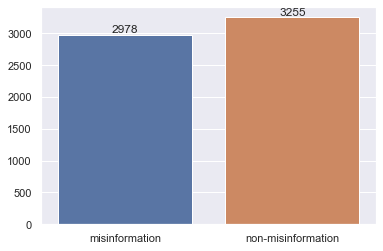

In [138]:
print('train')        
print_class_balance(df_train['misinformation'])

test


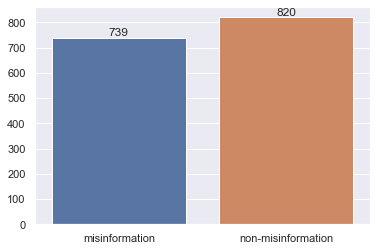

In [139]:
print('test')        
print_class_balance(df_test['misinformation'])

expanded test


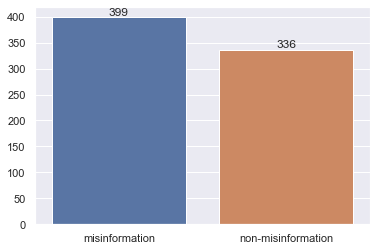

In [141]:
print('expanded test')        
print_class_balance(df_test[df_test['original']==0]['misinformation'])

In [126]:
###
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [137]:
def query(words,text):
    text = str(text).lower()
    for word in words:
        word = word.lower()    
        if word in text:
            return True
        else:
            return False
    
df_train[(df_train.apply(lambda x: query(['adicionem esse número','marqueteir','do jair', 'lista'], x['text']),axis=1))]['text'].values


array([], dtype=object)

In [136]:
df_test[df_test.apply(lambda x: query(['marqueteir', 'list'], x['text']),axis=1)]

,text,misinformation,original


In [129]:
df_train = df_train[(df_train.apply(lambda x: not query(['marqueteir'], x['text']),axis=1))]
df_train.to_csv('data/2018/train-test/train.csv', index = False)

In [135]:
df_test = df_test[(df_test.apply(lambda x: not query(['marqueteir'], x['text']),axis=1))]
df_test.to_csv('data/2018/train-test/test.csv', index = False)